## Download Data

In [1]:
# tr_path = "./data/covid.train.csv"
# tt_path = "./data/covid.test.csv"

tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 15.4MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 8.67MB/s]


## Import Some Packages

In [2]:
import os

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Sklearn
import sklearn
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing

# Pandas
import pandas as pd

# Random
import random

In [3]:
def set_seed(seed):
  """为所有常见的随机性来源设置种子"""
  np.random.seed(seed)    # 为 NumPy 设置种子
  random.seed(seed)       # 为 Python 内置 random 模块设置种子
  torch.manual_seed(seed) # 为 PyTorch CPU 设置种子
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed) # 为当前GPU设置种子
    torch.cuda.manual_seed_all(seed) # 为所有GPU设置种子（如果有多块）

  # 一些 CuDNN 基准优化操作本身具有不确定性，固定它们以保证可重复性
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  # 为 Python 环境变量设置种子（影响哈希等行为）
  os.environ['PYTHONHASHSEED'] = str(seed)

myseed = 42069
set_seed(myseed)

device_count = torch.cuda.device_count()
print(f"Number of CUDA devices: {device_count}")

Number of CUDA devices: 1


## Some Utilities

In [4]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

## Preprocess

We have three kinds of dataset:
- `train`: for training
- `dev`: for validation
- `test`: for testing (w/o target value)

### Dataset

The `COVID19Dataset` below does:
- read `.csv` files
- extract features
- split `covid.train.csv` into train/dev sets
- normalize features

Finishing `TODO` below might make you pass medium baseline.

In [5]:
class COVID19Dataset(Dataset):
    """Dataset for loading and preprocessing the COVID19 dataset"""
    def __init__(self, path:str , mode='train', target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
        else:
            # TODO: using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = list(range(40)) + [58, 76]

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2(18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2(18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices  = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            print("convert data into PyTorch tensors with ", indices)
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)
        self.dim = self.data.shape[1] # get features num, self.data.shape -> (num_samples, num_features)
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

### DataLoader

A `DataLoader` loads data from a given Dataset into batches.

In [6]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

## Deep Neural Network

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.

In [7]:
class NeuralNet(nn.Module):
    """A simple fully-connected deep neural network"""
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

        # 添加正则化参数
        self.l1_lambda = 0.001  # L1正则化系数
        self.l2_lambda = 0.001  # L2正则化系数

    def forward(self, x):
        """Given input of size (batch_size x input_dim), compute output of the network"""
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        """Caluculate loss"""
        # TODO: you may implement L1/L2 regularization here

        # 计算基础 MSE 损失
        mse_loss = self.criterion(pred, target)

        # 初始化正则化损失
        l1_reg_loss = 0
        l2_reg_loss = 0

        # 遍历所有参数，计算 L1 和 L2 正则化
        for name, param in self.named_parameters():
          if 'weight' in name: # 通常只对权重进行正则化，不包括偏置
            l1_reg_loss += torch.sum(torch.abs(param))
            l2_reg_loss += torch.sum(param**2)

        # 总损失 = MSE 损失 + L1 正则化 + L2 正则化
        total_loss = mse_loss + self.l1_lambda * l1_reg_loss + self.l2_lambda * l2_reg_loss

        return total_loss

## Train/Dev/Test

### Training

In [8]:
def train(tr_set, dv_set, model, config, device):
    """DNN training"""
    n_epochs = config['n_epochs'] # Maxium number of epoches

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas']
    )

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}     # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                          # set model to training mode
        for x, y in tr_set:                    # interate through the dataloader
            # print("x in train loop: ", x)
            # print("y in train loop: ", y)
            optimizer.zero_grad()              # set gradient to zero
            x, y = x.to(device), y.to(device)  # move data to device (CPU/GPU)
            pred = model(x)                    # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y) # compute loss
            mse_loss.backward()                # compute gradient (backpropagation)
            optimizer.step()                   # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path']) # Save model to specified path
            early_stop_cnt = 0
        else:
            print("case: dev_mse >= min_mse")
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

      print('Finished training after {} epochs'.format(epoch))
      return min_mse, loss_record


### Validation

In [9]:
def dev(dv_set, model, device):
    """DNN validation"""
    model.eval()                                              # set model to evaluation mode

    total_loss = 0

    for x, y in dv_set:                                       # interate through the dataloader
        x, y = x.to(device), y.to(device)                     # move data to device (CPU/GPU)
        with torch.no_grad():                                 # disable gradient calculation
            pred = model(x)                                   # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)                # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x) # accumulate loss

    total_loss = total_loss / len(dv_set.dataset)             # compute averaged loss

    return total_loss


### Testing

In [10]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

## Setup Hyper-parameters

`config` contains hyper-parameters for training and the path to save your model.

In [11]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}
print("device: ", device)

device:  cuda


## Load data and model

In [12]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
print("tr_set.dataset.dim :", tr_set.dataset.dim)
print("tr_set.dataset :", tr_set.dataset)
print("tr_set.dataset :", tr_set.dataset[1:])

dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

convert data into PyTorch tensors with  [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235

In [13]:
model = NeuralNet(tr_set.dataset.dim).to(device) # Construct model and move to device

## Start Training !

In [52]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 1.9809)
Finished training after 1 epochs


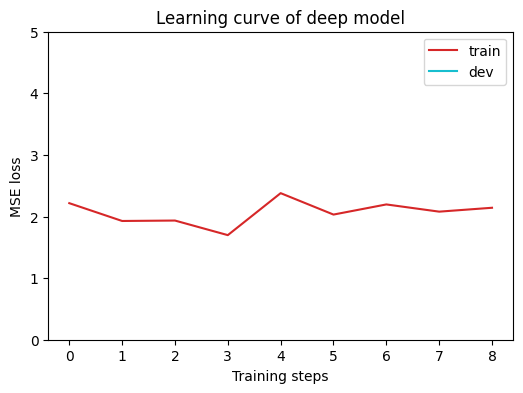

In [53]:
plot_learning_curve(model_loss_record, title='deep model')

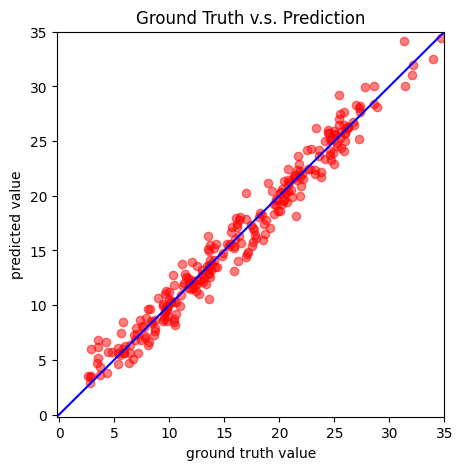

In [54]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu') # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device) # Show prediction on the validation set

## Testing

In [56]:
def save_pred(preds, file):
    """Save predictions to specified file"""
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device) # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')        # save prediction to pred.csv

Saving results to pred.csv
